### Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB

df_fac = pd.read_csv('data/child_care_regulated.csv') 
df_pop = pd.read_csv('data/population.csv')
df_income = pd.read_csv('data/avg_individual_income.csv')
df_emp = pd.read_csv('data/employment_rate.csv')

df_fac['zip_code'] = df_fac['zip_code'].apply(lambda x:int(str(x)[:5]))
df_income["ZIP code"] = df_income["ZIP code"].apply(lambda x:int(str(x)[:5]))
df_pop['zipcode'] = df_pop['zipcode'].apply(lambda x:int(str(x)[:5]))
df_emp['zipcode'] = df_emp['zipcode'].apply(lambda x:int(str(x)[:5]))

zip_codes = list(
        set(pd.read_csv('data/potential_locations.csv')['zipcode']) & set(df_pop['zipcode'])
    )


l = len(zip_codes)
print('number of regions: ',l)
print('coverage ratio - facilities:', len(set(df_fac['zip_code'])& set(zip_codes))/l) #& set(zip_codes)
print('coverage ratio - population:', len(set(df_pop['zipcode'])& set(zip_codes))/l)
print('coverage ratio - income:', len(set(df_income["ZIP code"])& set(zip_codes))/l)
print('coverage ratio - employment:', len(set(df_emp['zipcode'])& set(zip_codes))/l)


# Get income, employment_rate and population of each zip code
income = dict(zip(df_income["ZIP code"], df_income["average income"]))
emp = dict(zip(df_emp["zipcode"], df_emp["employment rate"]))
pop_tot,pop_under5 = {},{}
for _, r in df_pop.iterrows():
    pop_under5[r['zipcode']] = r['-5']
    pop_tot[r['zipcode']] = r['-5'] + r['5-9'] + int(3/5 * r['10-14'])

# Calculate the minimum number of slots and slots for children aged 0-5
min_slots_tot, min_slots_under5, k = {},{},0
avg_income, avg_emp = sum(income.values())/len(income), sum(emp.values())/len(emp)
avg_pop_tot, avg_pop_under5 = sum(pop_tot.values())/len(pop_tot), sum(pop_under5.values())/len(pop_under5)
for i in zip_codes:
    if emp.get(i,avg_emp) >= 0.6 or income.get(i,avg_income) <= 60000:
        min_slots_tot[i] = pop_tot.get(i,avg_pop_tot)/2 
        k += 1
    else:
        min_slots_tot[i] = pop_tot.get(i,avg_pop_tot)/3 
    min_slots_under5[i] = pop_under5.get(i,avg_pop_under5)*2/3
print('proportion of high-demand areas: ', k/l)

number of regions:  1646
coverage ratio - facilities: 0.6476306196840826
coverage ratio - population: 1.0
coverage ratio - income: 0.8353584447144593
coverage ratio - employment: 0.8353584447144593
proportion of high-demand areas:  0.3408262454434994


In [3]:
facility_types = {
    "small": {"cap": 100, "cap_0_5": 50, "cost": 65000},
    "medium": {"cap": 200, "cap_0_5": 100, "cost": 95000},
    "large": {"cap": 400, "cap_0_5": 200, "cost": 115000}
}

E = list(df_fac['facility_id'].unique())
cap = dict(zip(df_fac['facility_id'],df_fac['total_capacity'])) #current capacity
Emax = dict(zip(df_fac['facility_id'],df_fac['total_capacity'].apply(lambda x:min(1.2*x,500)))) #expanding limit
zip_e = dict(zip(df_fac['facility_id'],df_fac['zip_code']))
df_fac['under5_capacity'] = df_fac['infant_capacity'] + df_fac['toddler_capacity']
tmp = df_fac.groupby(['zip_code'])[['total_capacity','under5_capacity']].sum().reset_index()
existSlots = dict(zip(tmp["zip_code"], tmp["total_capacity"])) #existing slots 
exist0_5 = dict(zip(tmp["zip_code"], tmp["under5_capacity"]))

C_base = dict(zip(df_fac['facility_id'], 20000 + 200*df_fac['total_capacity'])) #baseline cost

### Problem 1

- Decision variable:   
Number of new facilities of three sizes ($n_{s}$), Expansion scale of existing facilities ($x_{e}$), Number of slots of new facilities for children aged 0-5($y\_new_{s}$), Number of expanded slots for children aged 0-5 ($y\_new_{e}$)  
$z$: Indicator for whether the expansion exceeds 100% of the current capacity (triggers baseline cost)  
For a existing facility e, set $x_e \geq \text{capacity}_e \cdot z_e$ and $x_e \leq\;\; (\text{cap}_e - 1) + M z_e$ , where M is a large number.  
$z=1$ -> current capacity <= expanding scale -> triggers baseline cost  
$z=0$ -> expanding scale < current capacity -> does not trigger baseline cost  

- Constraints:   
Minimum total number of slots, minimum number of slots for children aged 0-5, the number of slots for children aged 0–5 should not exceed the total number of expanded slots,  the upper limit on the slots for children aged 0–5 in new facilities, expansion limit.

- Objective function:  
Expansion cost + baseline cost + new facilities cost + additional cost for children aged 0-5.  
Expansion cost: the problem description does not provide a specific formula; the only information given is that it depends on the scale of the increase and that the marginal cost is decreasing. Here, we set it as a continuous piecewise linear function (to reduce computational cost), with breakpoints set according to the capacities of existing facilities. The per-slot cost is roughly scaled according to Problem 2. (A plot of the specific function is shown later.)

We solve each zip code separately to reduce the model size (solving them all together would exceed Gurobi's model size limit)

    

In [4]:
from tqdm import tqdm
results, objectives= {},{}

for i in tqdm(zip_codes):
    m = gp.Model(f"zip_{i}")
    m.Params.OutputFlag = 0 
    
    # Decision variables
    E_i = [e for e in E if zip_e[e]==i]
    n = m.addVars(facility_types.keys(), vtype=GRB.INTEGER, name="n") # Number of new facilities
    x = m.addVars(E_i, vtype=GRB.INTEGER, name="x") # Expansion scale of existing facilities
    z = m.addVars(E_i, vtype=GRB.BINARY, name="z") # Indicator for whether the expansion exceeds 100% of the current capacity (triggers baseline cost)
    y_new = m.addVars(facility_types.keys(), vtype=GRB.INTEGER, name="y_new")  # Number of slots of new facilities for children aged 0-5
    y_exp = m.addVars(E_i, vtype=GRB.INTEGER, name="y_exp")  # Number of expanded slots for children aged 0-5


    #Constraints
    for s in facility_types:
        m.addConstr(y_new[s] <= facility_types[s]["cap_0_5"] * n[s]) #capacity for 0-5
            
    for e in E_i:
        m.addConstr(y_exp[e] <= x[e]) # new slots for 0-5 <= total new slots

    # Minimum number of slots (total)
    m.addConstr(
        existSlots.get(i,0) #existing
        + gp.quicksum(x[e] for e in E_i) #expansion
        + gp.quicksum(facility_types[s]["cap"]*n[s] for s in facility_types) #new
        >= min_slots_tot[i],
        name = f'minimum number of slots_{i}'
    )

    # Minimum number of slots for children aged 0-5
    m.addConstr(
        exist0_5.get(i,0) #existing
        + gp.quicksum(y_exp[e] for e in E_i) #expansion
        + gp.quicksum(y_new[s] for s in facility_types) #new
        >= min_slots_under5[i],
        name = f'minimum number of slots for children aged 0-5_{i}'
    )

    # Expanding limit
    for e in E_i:
        m.addConstr(x[e] <= Emax[e], name = f'maximum expansion scale_{i}_{e}')

    # Indicator for whether the expansion exceeds 100% of the current capacity
    # z=1 -> current capacity <= expanding scale <= M (a large number)  -> triggers baseline cost
    # z=0 -> expanding scale < current capacity -> does not trigger baseline cost
    M = 1e6 
    for e in E_i:
        m.addConstr(x[e] >= cap[e]*z[e])
        m.addConstr(x[e] <= (cap[e]-1) + M*z[e])


    # Objective function

    # Expansion cost with decreasing marginal cost (continuous piecewise function)
    cost_exp = m.addVars(E_i, vtype=GRB.CONTINUOUS, name="cost_exp")
    pwl_x = [0, 20, 50, 100, 200, 500]
    pwl_y = [
        0,                     # x=0
        1000*20,                # x=20
        1000*20 + 800*(50-20),  # x=50
        1000*20 + 800*(50-20) + 600*(100-50), # x=100
        1000*20 + 800*(50-20) + 600*(100-50) + 400*(200-100), # x=200
        1000*20 + 800*(50-20) + 600*(100-50) + 400*(200-100) + 200*(500-200) # x=500
    ]
    for e in E_i:
        m.addGenConstrPWL(x[e], cost_exp[e], pwl_x, pwl_y, name=f"pwl_{e}")

    # Expansion cost + baseline cost + additional cost for children aged 0-5
    obj = gp.quicksum(cost_exp[e] + C_base[e]*z[e] + 100*y_exp[e] for e in E_i)


    # New facilities cost + additional cost for children aged 0–5
    obj += gp.quicksum(
        facility_types[s]["cost"]*n[s] + 100*y_new[s] 
        for s in facility_types
    )
    
    m.setObjective(obj, GRB.MINIMIZE)
    m.optimize()
    results[i] = {v.VarName: int(v.X) for v in m.getVars()}
    objectives[i] = m.ObjVal

  0%|          | 0/1646 [00:00<?, ?it/s]

Restricted license - for non-production use only - expires 2026-11-23


100%|██████████| 1646/1646 [00:25<00:00, 64.20it/s] 


In [5]:
print('Average cost:',sum(objectives.values())/len(objectives))
print('Total cost:',sum(objectives.values()))

Average cost: 293733.90019725333
Total cost: 483485999.724679


Below is a function designed to make it easier to view the results. We checked two examples:

- For zip code 10001, the minimum funding is 301800, and the optimal solution is to build 1 large new facilities, with 200 slots allocated to children aged 0–5, expand facility 893683 by 291 slots, expand facility 837597 by 5 slots and allocate all expanded slots to children aged 0–5.

- For zip code 10005, the minimum funding is 262300, the optimal solution is to build 7 large new facilities with 1400 slots allocated to children aged 0–5, no expansion is needed.

- We manually verified the correctness of the results afterwards (including both the objective value and whether all constraints are satisfied).

In [6]:
def get_results(zip_code):
    obj = objectives[zip_code]
    res = results[zip_code]
    dict_new = {
                'small':(res['n[small]'],res['y_new[small]']),
                'medium':(res['n[medium]'],res['y_new[medium]']),
                'large':(res['n[large]'],res['y_new[large]'])
                }
    dict_exp = {}
    E_i =  [e for e in E if zip_e[e]==zip_code]
    for e in E_i:
        dict_exp[e] = (res[f'x[{e}]'],res[f'y_exp[{e}]'])
    return obj,dict_new, dict_exp

zip_code = 10001 #zip_codes[0]
obj,dict_new, dict_exp = get_results(zip_code)

print('Zip code: ',zip_code)
print('Minumum funding: ', obj)
print('New facilities and new slots for children aged 0-5:')
print(dict_new)
print('Expansion scale of existing facilities of existing facilities and slots for children aged 0-5: ')
print(sorted(dict_exp.items(), key=lambda item: item[1][0], reverse=True))

print()
zip_code = 10005 #zip_codes[4]
obj,dict_new, dict_exp = get_results(zip_code)
print('Zip code: ',zip_code)
print('Minumum funding: ', obj)
print('New facilities and new slots for children aged 0-5:')
print(dict_new)
print('Expansion scale of existing facilities of existing facilities and slots for children aged 0-5: ')
print(sorted(dict_exp.items(), key=lambda item: item[1][0], reverse=True))

Zip code:  10001
Minumum funding:  301800.0
New facilities and new slots for children aged 0-5:
{'small': (0, 0), 'medium': (0, 0), 'large': (1, 200)}
Expansion scale of existing facilities of existing facilities and slots for children aged 0-5: 
[(893683, (291, 291)), (837597, (5, 5)), (661697, (0, 0)), (837329, (0, 0)), (350076, (0, 0)), (292419, (0, 0)), (229433, (0, 0)), (827488, (0, 0)), (912862, (0, 0))]

Zip code:  10005
Minumum funding:  262300.0
New facilities and new slots for children aged 0-5:
{'small': (0, 0), 'medium': (0, 0), 'large': (2, 323)}
Expansion scale of existing facilities of existing facilities and slots for children aged 0-5: 
[(397219, (0, 0))]


Notes on expansion cost function  
We set it as a continuous piecewise linear function with decreasing marginal cost.  
The optimal expanding scale is closely related to the current capacity (we found that it is often set to current size - 1, to avoid triggering the baseline cost), so we set breakpoints according to the capacities of existing facilities (the following shows the mean and other statistics). The per-slot cost is roughly of the same order of magnitude as in Problem 2.  
We did not use higher-order functions, as that would turn the model into a nonlinear programming problem and greatly increase the computational cost.


Min: 0
Max: 890
Mean: 42.34266854652653
Median: 16.0
25th percentile: 16.0
75th percentile: 40.0


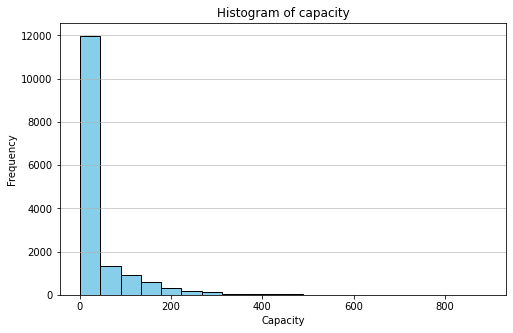

In [7]:
values = np.array(list(cap.values()))

minimum = np.min(values)
maximum = np.max(values)
mean = np.mean(values)
median = np.median(values)
q25 = np.percentile(values, 25)
q75 = np.percentile(values, 75)
print(f"Min: {minimum}")
print(f"Max: {maximum}")
print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"25th percentile: {q25}")
print(f"75th percentile: {q75}")

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(values, bins=20, color='skyblue', edgecolor='black') 
plt.title('Histogram of capacity')
plt.xlabel('Capacity')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [8]:
pwl_x = [0, 20, 50, 100, 200, 500]
pwl_y = [
    0,                                    # x=0
    1000*20,                              # x=20
    1000*20 + 800*(50-20),                # x=50
    1000*20 + 800*(50-20) + 600*(100-50), # x=100
    1000*20 + 800*(50-20) + 600*(100-50) + 400*(200-100), # x=200
    1000*20 + 800*(50-20) + 600*(100-50) + 400*(200-100) + 200*(500-200) # x=500
]
def expansion_cost(x):
    if x <= pwl_x[0]:
        return pwl_y[0]
    if x >= pwl_x[-1]:
        return pwl_y[-1]
    for i in range(1, len(pwl_x)):
        if x <= pwl_x[i]:
            x0, x1 = pwl_x[i-1], pwl_x[i]
            y0, y1 = pwl_y[i-1], pwl_y[i]
            return y0 + (y1 - y0) * (x - x0) / (x1 - x0)
expansion_cost(80)


62000.0

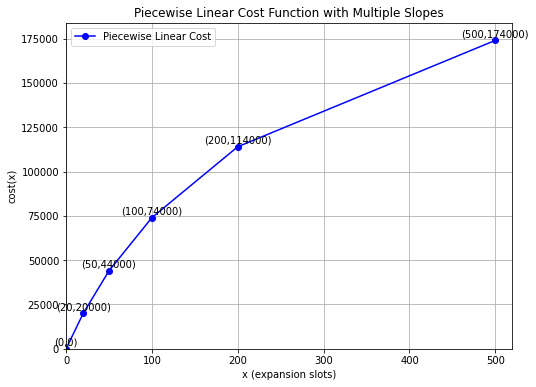

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(pwl_x, pwl_y, marker='o', color='b', label="Piecewise Linear Cost")

for x, y in zip(pwl_x, pwl_y):
    plt.text(x, y+2000, f"({x},{y})", ha='center')

plt.xlim(0, 520)
plt.ylim(0, max(pwl_y)+10000)
plt.xlabel("x (expansion slots)")
plt.ylabel("cost(x)")
plt.title("Piecewise Linear Cost Function with Multiple Slopes")
plt.grid(True)
plt.legend()
plt.show()


Manually verify two examples for correctness (objective value and constraint satisfaction)

In [10]:
"""
Zip code:  10001
Minumum funding:  301800.0
New facilities and new slots for children aged 0-5:
{'small': (0, 0), 'medium': (0, 0), 'large': (1, 200)}
Expansion scale of existing facilities of existing facilities and slots for children aged 0-5: 
[(893683, (291, 291)), (837597, (5, 5)), (661697, (0, 0)), (837329, (0, 0)), (350076, (0, 0)), (292419, (0, 0)), (229433, (0, 0)), (827488, (0, 0)), (912862, (0, 0))]
"""
for i in [893683,837597]:
    print(cap[i],end=' ')
    
print(expansion_cost(291) + expansion_cost(5) + 115000 + 100*(200+291+5))

z = 10027
print(min_slots_tot[z],min_slots_under5[z])
print(existSlots[z]+400+291+5 , exist0_5[z]+200+291+5)


292 84 301800.0
2951.3333333333335 2424.0
4454 496


The expansion size of existing facilities is often set to current size - 1 (start from the largest facility)  to avoid triggering the baseline cost (makes sense).

In [11]:
"""
Zip code:  10005
Minumum funding:  262300.0
New facilities and new slots for children aged 0-5:
{'small': (0, 0), 'medium': (0, 0), 'large': (2, 323)}
Expansion scale of existing facilities of existing facilities and slots for children aged 0-5: 
[(397219, (0, 0))]
"""

print(2*115000 + 323*100)
z = 10005 

print(min_slots_tot[z],min_slots_under5[z])
print(400*2,323)

262300
412.5 322.6666666666667
800 323


### Problem 2: Realistic Capacity Expansion and Location

1. Decision Variables

n_s: Number of new facilities to build, for each size type (small, medium, large).

x_e: Number of additional slots created by expanding existing facilities.

y_new: Number of new slots specifically for children aged 0–5 in new facilities.

y_exp: Number of new slots specifically for children aged 0–5 in expanded facilities.

y[p, s]: Binary variable (0 or 1) indicating whether a new facility of size s is built at site p.

Each ZIP code has its own set of candidate sites to choose from.

2. Constraints
Capacity and Demand

The total number of slots (existing + expanded + new) must be at least the required total demand for each ZIP code.

The total number of slots for children aged 0–5 must also meet the minimum required demand.

Expansion Limits

Expansion at any existing facility cannot exceed 20% of its current capacity or 500 slots (whichever is smaller).

Expansion cost depends on how many slots are added.

Site Rules

Each candidate site can host at most one new facility type.

The total number of new facilities of each type must equal the number of sites selected for that type.

Distance Constraints

If two candidate sites are closer than 0.06 miles, only one of them can be selected.

If a candidate site is too close to an existing facility, it cannot be selected.

3. Objective Function

We minimize the total cost, which includes:

Expansion cost — depends on how much each existing facility expands.

Breakpoints at 10%, 15%, and 20% of capacity.

New facility cost — fixed cost depending on whether it’s small, medium, or large.

Additional cost for children aged 0–5 — $100 per new or expanded slot for children aged 0–5.

4. Solution Approach

Solve the optimization problem separately for each ZIP code to keep the model size manageable.

This avoids running into solver limits while ensuring good results.

5. Outputs

results_p2[i]: Shows how many facilities to build or expand in each ZIP code.

objectives_p2[i]: Minimum cost for that ZIP code.


In [12]:
###############PROBLEM2################
import numpy as np
from collections import defaultdict
df_newloc=pd.read_csv('data/potential_locations.csv')

#####DISTANCE CALCULATION
# 1) Add site_id if missing (unique and readable: "<zip>_<k>")
df_newloc = df_newloc[df_newloc['zipcode'].isin(zip_codes)].copy()
if 'site_id' not in df_newloc.columns:
    df_newloc = df_newloc.copy().reset_index(drop=True)
    df_newloc['site_row'] = df_newloc.groupby('zipcode').cumcount()
    df_newloc['site_id'] = df_newloc['zipcode'].astype(str) + '_' + df_newloc['site_row'].astype(str)
    df_newloc.drop(columns=['site_row'], inplace=True)

# Safety: keep only rows with valid coords
df_newloc = df_newloc.dropna(subset=['latitude','longitude'])
df_newloc['latitude']  = df_newloc['latitude'].astype(float)
df_newloc['longitude'] = df_newloc['longitude'].astype(float)
df_newloc['site_id']   = df_newloc['site_id'].astype(str)

# distance formular
def haversine_mi(lat1, lon1, lat2, lon2):
    R_miles = 3958.7613
    φ1, φ2 = np.radians(lat1), np.radians(lat2)
    dφ = φ2 - φ1
    dλ = np.radians(lon2 - lon1)
    a = np.sin(dφ/2.0)**2 + np.cos(φ1) * np.cos(φ2) * np.sin(dλ/2.0)**2
    return 2.0 * R_miles * np.arcsin(np.sqrt(a))

SITE_SITE_MIN_MILES = 0.06  # your threshold

# 3) Build dict: ZIP -> list of (site_id_a, site_id_b) that are too close
site_pairs_too_close_by_zip = defaultdict(list)

for z in df_newloc['zipcode'].dropna().unique():
    sub = df_newloc[df_newloc['zipcode'] == z].reset_index(drop=True)
    n = len(sub)
    if n < 2:
        continue
    # pairwise upper triangle
    for a in range(n):
        lat1, lon1 = sub.loc[a, 'latitude'], sub.loc[a, 'longitude']
        # vectorize distances from a to a+1..end
        d = haversine_mi(lat1, lon1, sub.loc[a+1:, 'latitude'].values, sub.loc[a+1:, 'longitude'].values)
        close_idx = np.where(d < SITE_SITE_MIN_MILES)[0]
        for off in close_idx:
            b = a + 1 + off
            site_pairs_too_close_by_zip[z].append((sub.loc[a, 'site_id'], sub.loc[b, 'site_id']))
# 3) Build dict: ZIP -> list of (site_id_a, exist_id) that are too close
SITE_EXIST_MIN_MILES=0.06
site_exist_forbidden_by_zip= defaultdict(list)
for z in zip_codes:
    sub_e=df_fac[df_fac['zip_code']==z].reset_index(drop=True)
    sub_p= df_newloc[df_newloc['zipcode'] == z].reset_index(drop=True)
    for e_idx in sub_e.index:
        lat1 = sub_e.at[e_idx, 'latitude']
        lon1 = sub_e.at[e_idx, 'longitude']
        for p_idx in sub_p.index:
            lat2 = sub_p.at[p_idx, 'latitude']
            lon2 = sub_p.at[p_idx, 'longitude']
            d = haversine_mi(lat1, lon1, lat2, lon2)
            if d < SITE_EXIST_MIN_MILES:
                site_exist_forbidden_by_zip[z].append((str(sub_p.at[p_idx,'site_id']), sub_e.at[e_idx,'facility_id']))

#####OPTIMIZATION
from tqdm import tqdm
results_p2, objectives_p2= {},{}
S = list(facility_types.keys()) 

for i in tqdm(zip_codes):
    m2 = gp.Model(f"zip_{i}")
    m2.Params.OutputFlag = 0 
    
    # Decision variables
    E_i = [e for e in E if zip_e[e]==i]
    P_i = df_newloc.loc[df_newloc['zipcode'] == i, 'site_id'].astype(str).tolist()
    n = m2.addVars(facility_types.keys(), vtype=GRB.INTEGER, name="n") # Number of new facilities
    y = m2.addVars(P_i, S, vtype=GRB.BINARY, name="y_site")# indicator variable:whether to build size s builidng at location pi
    x = m2.addVars(E_i, vtype=GRB.INTEGER, name="x") # Expansion scale of existing facilities
    y_new = m2.addVars(facility_types.keys(), vtype=GRB.INTEGER, name="y_new")  # Number of slots of new facilities for children aged 0-5
    y_exp = m2.addVars(E_i, vtype=GRB.INTEGER, name="y_exp")  # Number of expanded slots for children aged 0-5


    ###Constraints
    
    for s in facility_types:
        m2.addConstr(y_new[s] <= facility_types[s]["cap_0_5"] * n[s]) #capacity for 0-5
            
    for e in E_i:
        m2.addConstr(y_exp[e] <= x[e]) # new slots for 0-5 <= total new slots

    # each site can host at most one type
    m2.addConstrs((gp.quicksum(y[p, s] for s in S) <= 1 for p in P_i), name="one_type_per_site")
    # link counts: n[s] = number of chosen sites of type s in ZIP i
    for s in S:
        m2.addConstr(n[s] == gp.quicksum(y[p, s] for p in P_i), name=f"count_type[{s}]")
    # Minimum number of slots (total)
    m2.addConstr(
        existSlots.get(i,0) #existing
        + gp.quicksum(x[e] for e in E_i) #expansion
        + gp.quicksum(facility_types[s]["cap"]*n[s] for s in facility_types) 
        >= min_slots_tot[i],
        name = f'minimum number of slots_{i}'
    )

    # Minimum number of slots for children aged 0-5
    m2.addConstr(
        exist0_5.get(i,0) #existing
        + gp.quicksum(y_exp[e] for e in E_i) #expansion
        + gp.quicksum(y_new[s] for s in facility_types) #new
        >= min_slots_under5[i],
        name = f'minimum number of slots for children aged 0-5_{i}'
    )

     #distance constraint
    for (pa, pb) in site_pairs_too_close_by_zip.get(i, []):
        if pa in P_i and pb in P_i:
            m2.addConstr(
                gp.quicksum(y[pa, s] for s in S) + gp.quicksum(y[pb, s] for s in S) <= 1,
                name=f"no_two_close[{pa},{pb}]"
            )
    
    for (p, e) in site_exist_forbidden_by_zip.get(i, []):
        if p in P_i:
            m2.addConstr(
                gp.quicksum(y[p, s] for s in S) == 0,
                name=f"no_near_existing[{p},{e}]"
            )

    
    ### Objective function
    obj = gp.LinExpr(0.0)
    # Expansion cost  
    for e in E_i:
        nf = cap[e]
        if nf <= 0:
            m2.addConstr(x[e] == 0,      name=f"x_zero_cap[{i},{e}]")
            m2.addConstr(y_exp[e] == 0,  name=f"yexp_zero_cap[{i},{e}]")
            continue
        # breakpoints in x (absolute slot amounts)
        bp = [0, 0.1*nf, 0.15*nf, 0.2*nf]
    
        # cost function
        cost_bp = [
            0,
            (20000 + 200*nf)   * (0.1*nf/nf),
            (20000 + 400*nf)   * (0.15*nf/nf),
            (20000 + 1000*nf)  * (0.2*nf/nf)
        ]
    
        m2.setPWLObj(x[e], bp, cost_bp)
        #expand constraint
        x_max = min(0.2 * cap[e], 500.0)
        m2.addConstr(x[e] <= x_max, name=f"x_cap[{i},{e}]")
        #expand children aged 0-5 constraint
        m2.addConstr(y_exp[e] <= x[e], name=f"child0-5_cap[{i},{e}]")

   
    # + additional cost for children aged 0-5
    obj += gp.quicksum( 100*y_exp[e] for e in E_i)


    # + New facilities cost + additional cost for children aged 0–5
    obj += gp.quicksum(
        facility_types[s]["cost"]*n[s] + 100*y_new[s] 
        for s in facility_types
    )
    
    m2.setObjective(obj, GRB.MINIMIZE)
    m2.optimize()
    results_p2[i] = {v.VarName: int(v.X) for v in m2.getVars()}
    objectives_p2[i] = m2.ObjVal

In [ ]:
sum(objectives_p2.values())

451366600.0

#### Checking if the distance constraint is satsified 
verify that the optimized site selection respects minimum distance rules. It checks whether any selected new sites are too close to each other or to existing facilities, helping ensure the final solution is feasible, realistic, and compliant with spatial constraints before implementation.

In [ ]:
import re
chosen_by_zip = {}

for z, varmap in results_p2.items():
    chosen_sites = set()
    for k, v in varmap.items():
        if k.startswith("y_site") and int(v) == 1:
            # Parse variable name: y_site[site_id, type]
            m = re.match(r"y_site\[(.*)\]$", k)
            if not m:
                continue
            inside = m.group(1).strip()
            parts = [p.strip() for p in inside.split(",", 1)]
            if not parts:
                continue
            site_token = parts[0]
            # strip quotes if present
            if (site_token.startswith("'") and site_token.endswith("'")) or (site_token.startswith('"') and site_token.endswith('"')):
                site_token = site_token[1:-1]
            chosen_sites.add(site_token)
    chosen_by_zip[z] = chosen_sites

# === STEP 2: Run distance checks ===
viol_site_site = []
viol_site_exist = []

# (a) new–new site distance
for z, pairs in site_pairs_too_close_by_zip.items():
    chosen = chosen_by_zip.get(z, set())
    for (pa, pb) in pairs:
        if (pa in chosen) and (pb in chosen):
            viol_site_site.append((z, pa, pb))

# (b) new–existing distance
for z, pairs in site_exist_forbidden_by_zip.items():
    chosen = chosen_by_zip.get(z, set())
    for (p, e) in pairs:
        if p in chosen:
            viol_site_exist.append((z, p, e))

# === STEP 3: Report results ===
print("\n=== Distance Check ===")
print({
    "num_new_site_pairs_too_close": len(viol_site_site),
    "num_new_vs_existing_too_close": len(viol_site_exist)
})

if viol_site_site:
    print("\nSample new–new violations (zip, site_a, site_b):")
    for rec in viol_site_site[:5]:
        print(rec)

if viol_site_exist:
    print("\nSample new–existing violations (zip, new_site, existing_facility):")
    for rec in viol_site_exist[:5]:
        print(rec)



=== Distance Check ===
{'num_new_site_pairs_too_close': 0, 'num_new_vs_existing_too_close': 0}


## Post-Optimization Expansion Cost and Capacity Analysis
This code is designed to understand how the optimization model allocated capacity through facility expansions. It pulls expansion decisions from the model results, combines them with facility data, and calculates costs using a piecewise cost function. By summarizing results at both the facility and ZIP code levels, it reveals how much capacity was added through expansion and how much it cost. In simpler terms, it helps evaluate whether the model made smart, cost-effective use of existing facilities before turning to new construction.

In [ ]:
import re
import pandas as pd
import numpy as np

# 1) Build a dataframe of expansions from results_p2
# results_p2 looks like: { zip_i : { 'x[<facility_id>]': value, 'y_site[...]': ..., ... }, ... }
rows = []
for z, varmap in results_p2.items():
    for k, v in varmap.items():
        if k.startswith("x["):
            # robustly grab facility_id between brackets, handling quotes if present
            m = re.match(r"x\[(.*)\]$", k)
            if not m:
                continue
            raw_id = m.group(1).strip()
            # strip quotes if like x['1234'] or x["1234"]
            if (raw_id.startswith("'") and raw_id.endswith("'")) or (raw_id.startswith('"') and raw_id.endswith('"')):
                raw_id = raw_id[1:-1]
            rows.append({"zipcode": z, "facility_id": str(raw_id), "expanded_slots": int(v)})

df_exp = pd.DataFrame(rows)

# 2) Prepare facility data and merge expansions
fac = df_fac.rename(columns={
    "zip_code":"zipcode",
    "latitude":"lat",
    "longitude":"lon",
    "total_capacity":"current_capacity"
}).copy()

# Ensure IDs are comparable as strings
fac["facility_id"] = fac["facility_id"].astype(str)

# Merge solved expansions; if a facility had no x var, assume 0
fac = fac.merge(df_exp[["facility_id","expanded_slots"]], on="facility_id", how="left")
fac["expanded_slots"] = fac["expanded_slots"].fillna(0).astype(int)

# 3) Clean numeric types
fac["current_capacity"] = pd.to_numeric(fac["current_capacity"], errors="coerce").fillna(0).astype(int)

# 4) Cost formula (Problem 2)
def piecewise_expansion_cost(nf, x):
    if pd.isna(nf) or pd.isna(x) or nf <= 0 or x <= 0:
        return 0.0
    r = x / nf
    if r <= 0.10:
        return (20000 + 200 * nf) * r
    elif r <= 0.15:
        return (20000 + 400 * nf) * r
    elif r <= 0.20:
        return (20000 + 1000 * nf) * r
    else:
        return np.inf

# 5) Expansion ratio and costs
fac["expansion_ratio"] = np.where(
    fac["current_capacity"] > 0,
    fac["expanded_slots"] / fac["current_capacity"],
    0.0
)
fac["expansion_cost"] = [
    piecewise_expansion_cost(nf, x)
    for nf, x in zip(fac["current_capacity"], fac["expanded_slots"])
]

# 6) ZIP aggregation + totals
zip_summary = fac.groupby("zipcode", dropna=False).agg(
    total_capacity=("current_capacity","sum"),
    total_expanded=("expanded_slots","sum"),
    total_expansion_cost=("expansion_cost","sum")
).reset_index()

zip_summary["expansion_ratio_zip"] = np.where(
    zip_summary["total_capacity"] > 0,
    zip_summary["total_expanded"] / zip_summary["total_capacity"],
    np.nan
)

total_expanded = int(fac["expanded_slots"].sum())
total_exp_cost  = float(fac["expansion_cost"].replace(np.inf, np.nan).sum(skipna=True))
overall_ratio = (
    total_expanded / fac["current_capacity"].sum()
    if fac["current_capacity"].sum() > 0 else 0
)

print("=== Problem 2 Expansion Summary ===")
print({
    "total_expanded_slots": total_expanded,
    "total_expansion_cost": round(total_exp_cost, 2),
    "overall_expansion_ratio": round(overall_ratio, 4)
})

print("\n— Expansion by ZIP (first 8 rows) —")
print(zip_summary.head(8)[["zipcode","total_capacity","total_expanded","expansion_ratio_zip","total_expansion_cost"]])

print("\n— Sample Facility-Level Ratios (first 8 rows) —")
print(fac[["zipcode","facility_id","current_capacity","expanded_slots","expansion_ratio","expansion_cost"]].head(8))


=== Problem 2 Expansion Summary ===
{'total_expanded_slots': 120436, 'total_expansion_cost': 171060005.63, 'overall_expansion_ratio': 0.1823}

— Expansion by ZIP (first 8 rows) —
   zipcode  total_capacity  total_expanded  expansion_ratio_zip  \
0    10001             609             117             0.192118   
1    10002            4729             926             0.195813   
2    10003            1995             396             0.198496   
3    10004             263              52             0.197719   
4    10005              39               7             0.179487   
5    10006             156              31             0.198718   
6    10007             284              56             0.197183   
7    10009            1784             349             0.195628   

   total_expansion_cost  
0          1.470521e+05  
1          1.114467e+06  
2          4.236901e+05  
3          5.907692e+04  
4          1.058974e+04  
5          3.497436e+04  
6          6.743746e+04  
7        

#### Corresponding New facilities built for the first 8 zipcodes

In [ ]:
import re
import pandas as pd

# === STEP 1: Extract new facilities from results_p2 ===
rows_newfac = []
for z, varmap in results_p2.items():
    for k, v in varmap.items():
        if k.startswith("y_site") and int(v) == 1:
            # parse variable name: y_site[site_id, type]
            m = re.match(r"y_site\[(.*)\]$", k)
            if not m:
                continue
            inside = m.group(1).strip()
            parts = [p.strip() for p in inside.split(",", 1)]
            if not parts:
                continue
            site_token = parts[0]
            # strip quotes if present
            if (site_token.startswith("'") and site_token.endswith("'")) or (site_token.startswith('"') and site_token.endswith('"')):
                site_token = site_token[1:-1]
            rows_newfac.append({"zipcode": z, "site_id": site_token, "count": 1})

# create dataframe
df_newfac = pd.DataFrame(rows_newfac)

# === STEP 2: Aggregate for your target ZIP codes ===
target_zipcodes = [10001, 10002, 10003, 10004, 10005, 10006, 10007, 10009]

df_newfac_filtered = df_newfac[df_newfac["zipcode"].isin(target_zipcodes)]

if not df_newfac_filtered.empty:
    newfac_by_zip_filtered = df_newfac_filtered.groupby("zipcode")["count"].sum().reset_index()
    total_new_facilities_filtered = df_newfac_filtered["count"].sum()
else:
    newfac_by_zip_filtered = pd.DataFrame(columns=["zipcode", "count"])
    total_new_facilities_filtered = 0

print("=== New Facilities Built (Problem 2 — Selected ZIP Codes) ===")
print(f"Total new facilities built in target ZIPs: {total_new_facilities_filtered}")
print("\nBy ZIP:")
print(newfac_by_zip_filtered)


=== New Facilities Built (Problem 2 — Selected ZIP Codes) ===
Total new facilities built in target ZIPs: 20

By ZIP:
   zipcode  count
0    10001      2
1    10002      3
2    10003      3
3    10004      2
4    10005      2
5    10006      1
6    10007      2
7    10009      5


In [ ]:
import numpy as np
from collections import defaultdict

# Manhattan (L1) distance in MILES using lat/lon.
# 1° latitude ≈ 69.0 miles; 1° longitude ≈ 69.172 * cos(mean_lat)
def manhattan_mi(lat1, lon1, lat2, lon2):
    lat1 = np.asarray(lat1, dtype=float)
    lon1 = np.asarray(lon1, dtype=float)
    lat2 = np.asarray(lat2, dtype=float)
    lon2 = np.asarray(lon2, dtype=float)

    dlat = np.abs(lat2 - lat1)
    dlon = np.abs(lon2 - lon1)
    mean_lat_rad = np.radians((lat1 + lat2) / 2.0)

    miles_per_deg_lat = 69.0
    miles_per_deg_lon = 69.172 * np.cos(mean_lat_rad)

    return miles_per_deg_lat * dlat + miles_per_deg_lon * dlon

SITE_SITE_MIN_MILES  = 0.06
SITE_EXIST_MIN_MILES = 0.06

# 1) Keep only usable candidate rows
df_newloc = df_newloc[df_newloc['zipcode'].isin(zip_codes)].copy()
if 'site_id' not in df_newloc.columns:
    df_newloc = df_newloc.copy().reset_index(drop=True)
    df_newloc['site_row'] = df_newloc.groupby('zipcode').cumcount()
    df_newloc['site_id']  = df_newloc['zipcode'].astype(str) + '_' + df_newloc['site_row'].astype(str)
    df_newloc.drop(columns=['site_row'], inplace=True)

df_newloc = df_newloc.dropna(subset=['latitude','longitude'])
df_newloc['latitude']  = df_newloc['latitude'].astype(float)
df_newloc['longitude'] = df_newloc['longitude'].astype(float)
df_newloc['site_id']   = df_newloc['site_id'].astype(str)

# 2) Build: ZIP -> list of (site_id_a, site_id_b) that are too close (Manhattan)
site_pairs_too_close_by_zip = defaultdict(list)

for z in df_newloc['zipcode'].dropna().unique():
    sub = df_newloc[df_newloc['zipcode'] == z].reset_index(drop=True)
    n = len(sub)
    if n < 2:
        continue

    # pairwise upper triangle
    for a in range(n - 1):
        lat1, lon1 = sub.loc[a, 'latitude'], sub.loc[a, 'longitude']
        lat2 = sub.loc[a+1:, 'latitude'].values
        lon2 = sub.loc[a+1:, 'longitude'].values

        d = manhattan_mi(lat1, lon1, lat2, lon2)
        close_idx = np.where(d < SITE_SITE_MIN_MILES)[0]
        for off in close_idx:
            b = a + 1 + off
            site_pairs_too_close_by_zip[z].append((sub.loc[a, 'site_id'], sub.loc[b, 'site_id']))

# 3) Build: ZIP -> list of (site_id, exist_facility_id) that are too close (Manhattan)
site_exist_forbidden_by_zip = defaultdict(list)

for z in zip_codes:
    sub_e = df_fac[df_fac['zip_code'] == z].dropna(subset=['latitude','longitude']).reset_index(drop=True)
    sub_p = df_newloc[df_newloc['zipcode'] == z].reset_index(drop=True)
    if sub_p.empty or sub_e.empty:
        continue

    lat_e = sub_e['latitude'].astype(float).values
    lon_e = sub_e['longitude'].astype(float).values

    for idx_p, row_p in sub_p.iterrows():
        d = manhattan_mi(row_p['latitude'], row_p['longitude'], lat_e, lon_e)
        if np.any(d < SITE_EXIST_MIN_MILES):
            site_exist_forbidden_by_zip[z].append((str(row_p['site_id']), 'ANY_EXISTING'))

print("Manhattan-distance constraints built:",
      f"{sum(len(v) for v in site_pairs_too_close_by_zip.values())} site-site pairs,",
      f"{sum(len(v) for v in site_exist_forbidden_by_zip.values())} site-existing forbids")


NameError: name 'df_newloc' is not defined

### Problem 3

In [3]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from scipy.spatial import cKDTree
import gurobipy as gp
from gurobipy import GRB

# -------------------------------
# Step 1: Load datasets
# -------------------------------
df_fac = pd.read_csv('data/child_care_regulated.csv')
df_pop = pd.read_csv('data/population.csv')
df_income = pd.read_csv('data/avg_individual_income.csv')
df_emp = pd.read_csv('data/employment_rate.csv')
df_newloc = pd.read_csv('data/potential_locations.csv')

# -------------------------------
# Step 2: Normalize zipcodes
# -------------------------------
def normalize_zip(df):
    zip_col = None
    for c in df.columns:
        if 'zip' in c.lower():
            zip_col = c
            break
    df = df.copy()
    if zip_col:
        df['zipcode'] = df[zip_col].astype(str).str.extract(r'(\d{3,5})')[0].fillna('').str.zfill(5)
    else:
        df['zipcode'] = ''
    return df

df_fac = normalize_zip(df_fac)
df_pop = normalize_zip(df_pop)
df_income = normalize_zip(df_income)
df_emp = normalize_zip(df_emp)
df_newloc = normalize_zip(df_newloc)

# -------------------------------
# Step 3: Prepare site tables
# -------------------------------
existing_sites = df_fac.rename(columns={'total_capacity': 'capacity'})[
    ['facility_id', 'latitude', 'longitude', 'zipcode', 'capacity']
].dropna(subset=['latitude','longitude']).reset_index(drop=True)

df_newloc = df_newloc.copy()
df_newloc['id'] = range(len(df_newloc))
new_sites = df_newloc[['id', 'latitude', 'longitude', 'zipcode']].dropna(subset=['latitude','longitude']).reset_index(drop=True)

n_existing = len(existing_sites)
n_new = len(new_sites)
print(f"Existing facilities: {n_existing}, Potential new sites: {n_new}")

# -------------------------------
# Step 4: Initialize model and variables
# -------------------------------
m = gp.Model("child_care_fairness")

x_expand = m.addVars(n_existing, lb=0, name="x_expand")  # expansion slots
y_new = m.addVars(n_new, vtype=GRB.BINARY, name="y_new")  # build or not
facility_capacity = {'small': 100, 'medium': 200, 'large': 400}
facility_costs = {'small': 65000, 'medium': 95000, 'large': 115000}
z_size = m.addVars(n_new, facility_capacity.keys(), vtype=GRB.BINARY, name="z_size")

# -------------------------------
# Step 5: Distance constraint (no two within 0.06 miles)
# -------------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 3958.8
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1-a))

coords = np.vstack([
    np.column_stack([existing_sites['latitude'], existing_sites['longitude']]),
    np.column_stack([new_sites['latitude'], new_sites['longitude']])
])
tree = cKDTree(coords)
pairs = tree.query_pairs(r=0.06/69.0)
too_close = []
for i,j in pairs:
    if haversine(coords[i,0],coords[i,1],coords[j,0],coords[j,1]) < 0.06:
        too_close.append((i,j))

for i,j in too_close:
    if i < n_existing and j >= n_existing:  # existing-new
        m.addConstr(y_new[j-n_existing] == 0, name=f"dist_exist_new_{i}_{j}")
    elif i >= n_existing and j >= n_existing:  # new-new
        m.addConstr(y_new[i-n_existing] + y_new[j-n_existing] <= 1, name=f"dist_new_new_{i}_{j}")
print(f"Added {len(too_close)} proximity constraints.")

# -------------------------------
# Step 6: Aggregate population data
# -------------------------------
zip_children_total, zip_children_under5 = {}, {}
for _, row in df_pop.iterrows():
    z = row['zipcode']
    under5 = row.get('-5',0)
    total = row.get('-5',0)+row.get('5-9',0)+row.get('10-14',0)+row.get('15-19',0)
    zip_children_total[z] = total
    zip_children_under5[z] = under5

# employment/income
emp = df_emp.set_index('zipcode').to_dict().get('employment rate',{})
inc = df_income.set_index('zipcode').to_dict().get('average income',{})
high_demand_zips = {z for z in set(emp)|set(inc) if emp.get(z,0)>=0.6 or inc.get(z,1e9)<=60000}

# capacity per zip
zip_capacity = existing_sites.groupby('zipcode')['capacity'].sum().to_dict()
exist_idx_by_zip = existing_sites.groupby('zipcode').indices
new_idx_by_zip = new_sites.groupby('zipcode').indices

# -------------------------------
# Step 7: Capacity & under-5 constraints
# -------------------------------
for z, total_children in zip_children_total.items():
    under5 = zip_children_under5.get(z,0)
    exist_idx = exist_idx_by_zip.get(z,[])
    new_idx = new_idx_by_zip.get(z,[])
    exp_sum = gp.quicksum(x_expand[i] for i in exist_idx) if len(exist_idx)>0 else 0
    new_sum = gp.quicksum(
        gp.quicksum(facility_capacity[s]*z_size[j,s] for s in facility_capacity.keys())
        for j in new_idx
    ) if len(new_idx)>0 else 0
    current_cap = zip_capacity.get(z,0)
    total_cap = current_cap + exp_sum + new_sum
    req = 0.5*total_children if z in high_demand_zips else total_children/3
    if total_children>0:
        m.addConstr(total_cap >= req, name=f"cap_zip_{z}")
    if under5>0:
        m.addConstr(total_cap >= (2/3)*under5, name=f"under5_zip_{z}")

# -------------------------------
# Step 8: Link new facility size
# -------------------------------
for j in range(n_new):
    m.addConstr(gp.quicksum(z_size[j,s] for s in facility_capacity.keys()) == y_new[j])

# -------------------------------
# Step 9: Expansion cost (piecewise)
# -------------------------------
cost_expand_var = {}
for i in range(n_existing):
    nf = existing_sites.loc[i,'capacity']
    x = x_expand[i]
    c = m.addVar(lb=0, name=f"cost_expand_{i}")
    if nf<=0:
        m.addConstr(x==0)
        m.addConstr(c==0)
        cost_expand_var[i]=c
        continue
    ratio = m.addVar(lb=0, ub=0.2, name=f"ratio_{i}")
    m.addConstr(ratio*nf==x)
    pwl_x = [0,0.1,0.15,0.2]
    pwl_y = [
        0,
        (20000+200*nf)*0.1,
        (20000+400*nf)*0.15,
        (20000+1000*nf)*0.2
    ]
    m.addGenConstrPWL(ratio, c, pwl_x, pwl_y)
    cost_expand_var[i]=c

total_cost = gp.quicksum(cost_expand_var[i] for i in range(n_existing))
total_cost += gp.quicksum(
    gp.quicksum(facility_costs[s]*z_size[j,s] for s in facility_capacity.keys())
    for j in range(n_new)
)

# -------------------------------
# Step 10: Fairness constraints + objective
# -------------------------------
# approximate 5–12 children
zip_children_5_12 = {}
for _, row in df_pop.iterrows():
    z = row['zipcode']
    c_5_9 = row.get('5-9',0)
    c_10_14 = row.get('10-14',0)
    zip_children_5_12[z] = c_5_9 + 0.6*c_10_14

# total capacity expr per zip
total_slots_expr_by_zip = {}
for z in zip_children_total.keys():
    current = zip_capacity.get(z,0)
    exist_idx = exist_idx_by_zip.get(z,[])
    new_idx = new_idx_by_zip.get(z,[])
    exp_sum = gp.quicksum(x_expand[i] for i in exist_idx) if len(exist_idx)>0 else 0
    new_sum = gp.quicksum(
        gp.quicksum(facility_capacity[s]*z_size[j,s] for s in facility_capacity.keys())
        for j in new_idx
    ) if len(new_idx)>0 else 0
    total_slots_expr_by_zip[z] = current + exp_sum + new_sum

coverage = {}
for z, total_children in zip_children_total.items():
    if total_children<=0:
        coverage[z]=m.addVar(lb=0,ub=0)
    else:
        cov = m.addVar(lb=0,name=f"cov_{z}")
        m.addConstr(cov*total_children==total_slots_expr_by_zip[z])
        coverage[z]=cov

cov_max = m.addVar(lb=0)
cov_min = m.addVar(lb=0)
for z in coverage.keys():
    m.addConstr(coverage[z]<=cov_max)
    m.addConstr(coverage[z]>=cov_min)
m.addConstr(cov_max-cov_min<=0.1, name="fairness_gap")
m.addConstr(total_cost<=100_000_000, name="budget_100M")

social_obj = gp.quicksum(
    ((2/3)*(zip_children_under5.get(z,0)/zip_children_total.get(z,1)) +
     (1/3)*(zip_children_5_12.get(z,0)/zip_children_total.get(z,1))) * coverage[z]
    for z in coverage.keys() if zip_children_total.get(z,0)>0
)
m.setObjective(social_obj, GRB.MAXIMIZE)

# -------------------------------
# Step 11: Solve and Output
# -------------------------------
m.Params.TimeLimit = 600
m.optimize()

if m.status in [GRB.OPTIMAL, GRB.TIME_LIMIT]:
    print(f"\nModel solved. Social coverage objective: {m.objVal:.6f}")
    print(f"Total cost used: {total_cost.getValue():,.2f}")
    print(f"Coverage gap: {cov_max.X - cov_min.X:.4f}")
    
    # sample output by zipcode
    rows = []
    for z in list(coverage.keys())[:10]:
        rows.append({
            'zipcode': z,
            'coverage': coverage[z].X,
            'children_total': zip_children_total.get(z,0),
            'slots_est': coverage[z].X * zip_children_total.get(z,0)
        })
    print("\nSample coverage by ZIP:")
    display(pd.DataFrame(rows))
else:
    print("Model infeasible or no solution found.")


Existing facilities: 15014, Potential new sites: 215400
Set parameter Username
Set parameter LicenseID to value 2705298
Academic license - for non-commercial use only - expires 2026-09-09
Added 243660 proximity constraints.
Set parameter TimeLimit to value 600
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26220.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  600

Optimize a model with 474824 rows, 908289 columns and 3415321 nonzeros
Model fingerprint: 0x0447e5df
Model has 15013 simple general constraints
  15013 PWL
Variable types: 46689 continuous, 861600 integer (861600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e-03, 7e-01]
  Bounds range     [2e-01, 1e+00]
  RHS range        [1e-01, 1e+08]
  PWLCon x range   [1e-01, 1e-01]
  PWLCon y range   [2e+03, 6e+04]
Pres